# Train a Model to Predict Band Gap Energy using the MDF
This notebook demonstrates how to create an model to predict the band gap energy of crystalline materials using data from the MDF. Specifically, we will use data from the 

In [1]:
%matplotlib inline
import globus_sdk
from utils.globus_client import DataSearchClient
from pymatgen import Composition
from pymatgen.core.periodic_table import Element
from matminer.descriptors import composition_features as cf
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook as tqdm
import numpy as np
import itertools
import json
import os
import pandas as pd
import requests
import os
import shutil
CLIENT_ID='0013a791-276e-4e31-8cbe-005a8cfe1ba2'

## Create GlobusAuth Client
*Note*: On your first time running this, it will ask for you to log into Globus

GlobusAuth is the tool the Materials Data Facility (and other Globus products) use for security. It allows you to us to use credentials from institutions (e.g., UIUC) to control access to data. 

This part of the notebook asks for your credentials and uses them to access restricted data. (The OQMD raw data is not yet fully open to the public.) It then creates clients that "black box" how Python is talking to Globus to get you access to the data. We're working to further simplify this process, so you can happily ignore this part if you'd prefer. I've explained what is going on if you are curious.

In [2]:
client = globus_sdk.NativeAppAuthClient(CLIENT_ID)

This part will ask for you to log in to Globus and then will save some security tokens to your computer. You'll only have to do this once

In [3]:
if not os.path.isfile('auth_data.json'):
    # Get scopes for all things Globus
    client.oauth2_start_flow(requested_scopes=' '.join([
        'urn:globus:auth:scope:data.materialsdatafacility.org:all',
        'urn:globus:auth:scope:transfer.api.globus.org:all',
        'urn:globus:auth:scope:datasearch.api.globus.org:all'
    ]),
                            refresh_tokens=True)
    authorize_url = client.oauth2_get_authorize_url()
    print('Please go to this URL and login: {0}'.format(authorize_url))

    # Get the tokens
    get_input = getattr(__builtins__, 'raw_input', input)
    auth_code = get_input(
        'Please enter the code you get after login here: ').strip()
    token_response = client.oauth2_exchange_code_for_tokens(auth_code)

    # Save to disk
    json.dump(token_response.by_resource_server, open('auth_data.json', 'w'))

Load in the authorization data from file

In [4]:
auth_data = json.load(open('auth_data.json'))

In [5]:
def get_authorization(resource, auth_data=auth_data):
    """Get a refresh token authorizer for a certain resource:
    :param resource: str, name of resource (ex: "datasearch.api.globus.org")
    :param auth_data: dict, tokens by resource (from Globus)"""
    return globus_sdk.RefreshTokenAuthorizer(
        auth_data[resource]['refresh_token'],
        client,
        access_token=auth_data[resource]['access_token'],
        expires_at=auth_data[resource]['expires_at_seconds'])
search_authorizer=get_authorization("datasearch.api.globus.org")
http_authorizer=get_authorization("data.materialsdatafacility.org")

Create the search client. This tool is a Python wrapper that handles authenticating with a website running our search

In [6]:
client = DataSearchClient("https://search.api.globus.org/", "mdf", authorizer=search_authorizer)

## Get All ICSD Calculations from the OQMD

In [7]:
query_string = 'mdf.source_name:oqmd AND (oqmd.configuration:static OR oqmd.configuration:standard) AND oqmd.converged:True'
result_records = client.search(query_string, advanced=True)
compound_count = result_records['total']
print('Found %d compounds'%compound_count)

Found 335300 compounds


Our web service currently limits only getting `10k` records at a time. This part of the code gets records in a series of chunk

*Note*: We are also working to this limitation of our web service invisible to users. 

In [8]:
%%time
all_oqmd_compounds = []
scroll_pos = 0
scroll_width = 10000
while len(all_oqmd_compounds) < compound_count * 0.02:
    result_records = client.search(query_string +
                                   ' AND mdf.scroll_id:>=%d AND mdf.scroll_id:<%d'%(scroll_pos, scroll_pos+scroll_width),
                                   advanced=True, limit=scroll_width)
    all_oqmd_compounds.extend(result_records['gmeta'])
    print('\rRetrieved %d/%d. Scroll position=%d'%(len(all_oqmd_compounds), compound_count, scroll_pos), end="")
    scroll_pos += scroll_width
print(' - All done!')

Retrieved 9905/335300. Scroll position=10000 - All done!
Wall time: 15 s


In [9]:
all_oqmd_compounds[0]

{'@datatype': 'GMetaResult',
 '@version': '2016-11-09',
 'content': [{'mdf': {'collection': 'OQMD',
    'composition': 'Mg2Si1',
    'elements': ['Si', 'Mg'],
    'ingest_date': '2017-07-12T18:57:23.430512Z',
    'links': {'landing_page': 'http://oqmd.org/analysis/calculation/1752032',
     'metadata': {'globus_endpoint': '82f1b5c6-6e9b-11e5-ba47-22000b92c6ec',
      'http_host': 'https://data.materialsdatafacility.org',
      'path': '/collections/oqmd/data/home/oqmd/libraries/dongshu/Mg/Si/27/static/metadata.json'},
     'outcar': {'globus_endpoint': '82f1b5c6-6e9b-11e5-ba47-22000b92c6ec',
      'http_host': 'https://data.materialsdatafacility.org',
      'path': '/collections/oqmd/data/home/oqmd/libraries/dongshu/Mg/Si/27/static'},
     'parent_id': '596670e4f2c0041b5cbb00aa'},
    'mdf-id': '59667113f2c0041b5cbb0742',
    'metadata_version': '0.3.0',
    'resource_type': 'record',
    'scroll_id': 1688,
    'source_name': 'oqmd',
    'title': 'OQMD - Mg2Si1'},
   'oqmd': {'band_gap

## Compile the Training Set
First transform the data into a Pandas DataFrame, 

In [10]:
data = pd.DataFrame([x['subject'] for x in all_oqmd_compounds], columns=['oqmd_url'])

Get the composition and OQMD

In [11]:
def get_data(entry):
    """Get the composition, structure, band gap, and stability of an entry given its search result
    
    :param entry: dict, metadata for an entry as returned by Globus search
    :return: Several items
        - str, composition of the material
        - float, band-gap energy of material
        - float, Energy per atom (eV/atom)"""
    
    
    # Get the metadata as a dict
    oqmd_data = entry['content'][0]['oqmd']
    
    # Return results
    return entry['content'][0]['mdf']['composition'], \
        oqmd_data.get('band_gap', np.nan), \
        oqmd_data['total_energy'].get('value', np.nan)

In [12]:
data['composition'], data['band_gap'], data['energy'] = list(zip(*[get_data(x) for x in all_oqmd_compounds]))

Convert compositions to `pymatgen` objects

In [13]:
data['composition_pmg'] = data['composition'].apply(lambda x: Composition(x))

Remove compounds w/o a `band_gap` or `stability` property

In [14]:
original_count = len(data)
data = data[~ np.logical_or(data['band_gap'].isnull(), data['energy'].isnull())]
print('Removed %d/%d entires'%(original_count - len(data), original_count))

Removed 5/9905 entires


Get only the groundstate and each composition

In [15]:
data['is_groundstate'] = False

In [16]:
data['composition_str'] = data['composition_pmg'].apply(lambda x: x.reduced_formula)

In [17]:
%%time
data.sort_values('energy', ascending=True, inplace=True)
n_compositions = len(set(data['composition_str']))

Wall time: 9.02 ms


In [18]:
%%time
for i,(gid,group) in enumerate(data.groupby('composition_str')):
    data.loc[group.iloc[0].name, 'is_groundstate'] = True
    print('\rCompleted: %d/%d'%(i+1,n_compositions), end="")
print(" - All done!")

Completed: 6497/6497 - All done!
Wall time: 18.1 s


In [19]:
original_count = len(data)
data = data[data['is_groundstate']]
print('Removed %d/%d entires'%(original_count - len(data), original_count))

Removed 3403/9900 entires


## Build an ML model
In this part of the notebook, we build a ML model using [scikit-learn](http://scikit-learn.org/stable/) and evaluate its performance using cross-validation.

### Part 1: Compute Representation
The first step in building a ML model is to convert the raw materials data (here: the composition) into the required input for an ML model: a finite list of quantitative attributes. In this example, we use the "general-purpose" attributes of [Ward *et al* 2016](https://www.nature.com/articles/npjcompumats201628).

In [20]:
feature_calculators = [cf.StoichAttributes(), cf.ElemPropertyAttributes(method="magpie"), \
                      cf.ValenceOrbitalAttributes(props=['frac']), cf.IonicAttributes()]

Get the feature names

In [21]:
feature_labels = list(itertools.chain.from_iterable([x.feature_labels() for x in feature_calculators]))

Compute the features

In [22]:
%%time
for fc in feature_calculators:
    data = fc.featurize_dataframe(data, col_id='composition_pmg')

Wall time: 9.72 s


In [23]:
print('Generated %d features'%len(feature_labels))
print('Training set size:', 'x'.join([str(x) for x in data[feature_labels].shape]))

Generated 145 features
Training set size: 6497x145


Remove entries with `NaN` or `infinite` features

In [24]:
original_count = len(data)
data = data[~ data[feature_labels].isnull().any(axis=1)]
print('Removed %d/%d entires'%(original_count - len(data), original_count))

Removed 0/6497 entires


### Part 2: Tuning Model Hyper-parameters
For brevity, we will only consider one ML algorithm in this example: [random forest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor). The "random forest" algorithm works by training many different decision tree models, where each is trained on a different subset of the dataset . Here, we tune one of the major parameters of the algoritm: the number features considered at each split in each decision tree

In [25]:
model = GridSearchCV(RandomForestRegressor(n_estimators=100),
                     param_grid=dict(max_features=range(8,15)),
                     scoring='neg_mean_squared_error',
                     n_jobs=-1,
                    cv=10)

In [26]:
model.fit(data[feature_labels], data['band_gap'])

GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_features': range(8, 15)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

Plot the tuning results. This shows the CV score as a function of the parameter we tuned "max features"

In [27]:
model.best_score_

-0.28321272677949821

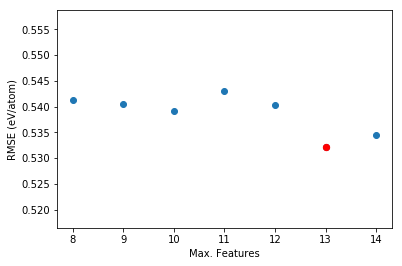

In [28]:
fig, ax = plt.subplots()

# Plot the score as a function of alpha
ax.scatter(model.cv_results_['param_max_features'].data,
          np.sqrt(-1 * model.cv_results_['mean_test_score']))
ax.scatter([model.best_params_['max_features']], np.sqrt([-1*model.best_score_]), marker='o', color='r', s=40)
ax.set_xlabel('Max. Features')
ax.set_ylabel('RMSE (eV/atom)')

Save our best model

In [29]:
model = model.best_estimator_

### Part 2: Cross-validation Test
Quantify the performance of this model using 10-fold cross-validation

In [30]:
cv_scores = cross_val_score(model, data[feature_labels], data['band_gap'], scoring='mean_absolute_error', cv=10, n_jobs=-1)

In [31]:
print('MAE: %.4f eV'%np.mean(-1 * cv_scores))

MAE: 0.1740 eV


Plot the individual predictions

In [32]:
cv_prediction = cross_val_predict(model, data[feature_labels], data['band_gap'], cv=10, n_jobs=-1)

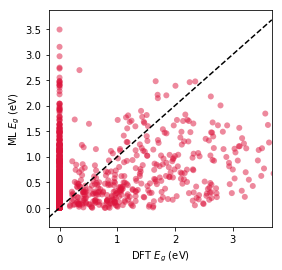

In [33]:
fig, ax = plt.subplots()

ax.scatter(data['band_gap'], cv_prediction, color='crimson', alpha=0.5, edgecolor='none')

ax.set_xlim(ax.get_ylim())

ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--')

ax.set_xlabel('DFT $E_g$ (eV)')
ax.set_ylabel('ML $E_g$ (eV)')

fig.set_size_inches(4, 4)